### Libraries

In [1]:
import os
import re
import ast
import pandas as pd
import networkx as nx
from pathlib import Path
from fa2 import ForceAtlas2
from nltk import word_tokenize
import matplotlib.pyplot as plt
import community as community_louvain

#### Import scripts

In [2]:
from Scripts.sentiment import sentiment_function
from Scripts.community_name import community_name
from Scripts.sentiment_VADER import compute_sentiment_VADER

#### Create the directories

In [3]:
Path("Images").mkdir(parents=True, exist_ok=True)
Path("Images/Networks").mkdir(parents=True, exist_ok=True)

#### Load data

In [4]:
char = pd.read_csv('./Data/Characters.csv')

#### Create the network

In [5]:
G = nx.DiGraph()

for filename in os.listdir(os.path.join(os.getcwd(), 'Data/Characters')):
    with open(os.path.join(os.path.join(os.getcwd(), 'Data/Characters'), filename), 'r') as f:
        contents = f.read()
        query_json = ast.literal_eval(contents)
        page_id = list(query_json['query']['pages'].keys())[0]
        string = query_json['query']['pages'][page_id]['revisions'][0]['slots']['main']['*']
                
        # Add nodes
        name = filename[:-4].replace('_',' ')
        G.add_node(name)
                
        # Add homeworld attribute
        G.nodes[name]['Homeworld'] = char.loc[char['Name']==name, 'Homeworld'].values[0]
        
        # Add species attribute
        G.nodes[name]['Species'] = char.loc[char['Name']==name, 'Species'].values[0]
        
        # Add gender
        G.nodes[name]['Gender'] = char.loc[char['Name']==name, 'Gender'].values[0]
        
        # Add edges
        pattern = '\[\[(.*?)(?:\|.*?)?\]\]'
        temp = re.findall(pattern, string)
        temp = list(char[char['Name'].isin(temp)]['Name'].drop_duplicates())
        for i in temp:
            G.add_edge(name, i)
            
G.remove_nodes_from(list(nx.isolates(G)))

#### Number of nodes

In [6]:
print("Number of nodes in the network:", G.number_of_nodes())

Number of nodes in the network: 4005


#### Number of edges

In [7]:
print("Number of links in the network:", G.number_of_edges())

Number of links in the network: 12709


#### In-degree network

In [8]:
connections_in = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)
print('In Degree Connections:')
for character, in_degree in connections_in[:10]:
    node = G.nodes[character]
    print(character.ljust(30), 'In-degree:', in_degree)

In Degree Connections:
Leia Organa Solo               In-degree: 246
Anakin Skywalker               In-degree: 147
Darth Sidious                  In-degree: 126
Leia Skywalker Organa Solo     In-degree: 104
Han Solo                       In-degree: 100
Luke Skywalker                 In-degree: 99
Darth Caedus                   In-degree: 90
Mara Jade Skywalker            In-degree: 81
Obi-Wan Kenobi                 In-degree: 74
Corran Horn                    In-degree: 68


#### Out-degree network

In [9]:
connections_out = sorted(dict(G.out_degree()).items(), key = lambda x: x[1], reverse = True)
print('\nOut Degree Connections:')
for character, out_degree in connections_out[:10]:
    node = G.nodes[character]
    print(character.ljust(30), 'Out-degree:', out_degree)


Out Degree Connections:
Darth Caedus                   Out-degree: 94
Anakin Skywalker               Out-degree: 87
Corran Horn                    Out-degree: 82
Leia Skywalker Organa Solo     Out-degree: 79
Jaina Solo Fel                 Out-degree: 65
Leia Organa Solo               Out-degree: 62
Tycho Celchu                   Out-degree: 56
Luke Skywalker                 Out-degree: 55
Obi-Wan Kenobi                 Out-degree: 50
Ezra Bridger                   Out-degree: 50


#### Visualize network

100%|██████████| 1000/1000 [00:58<00:00, 17.13it/s]


BarnesHut Approximation  took  22.65  seconds
Repulsion forces  took  32.75  seconds
Gravitational forces  took  0.20  seconds
Attraction forces  took  0.22  seconds
AdjustSpeedAndApplyForces step  took  1.11  seconds


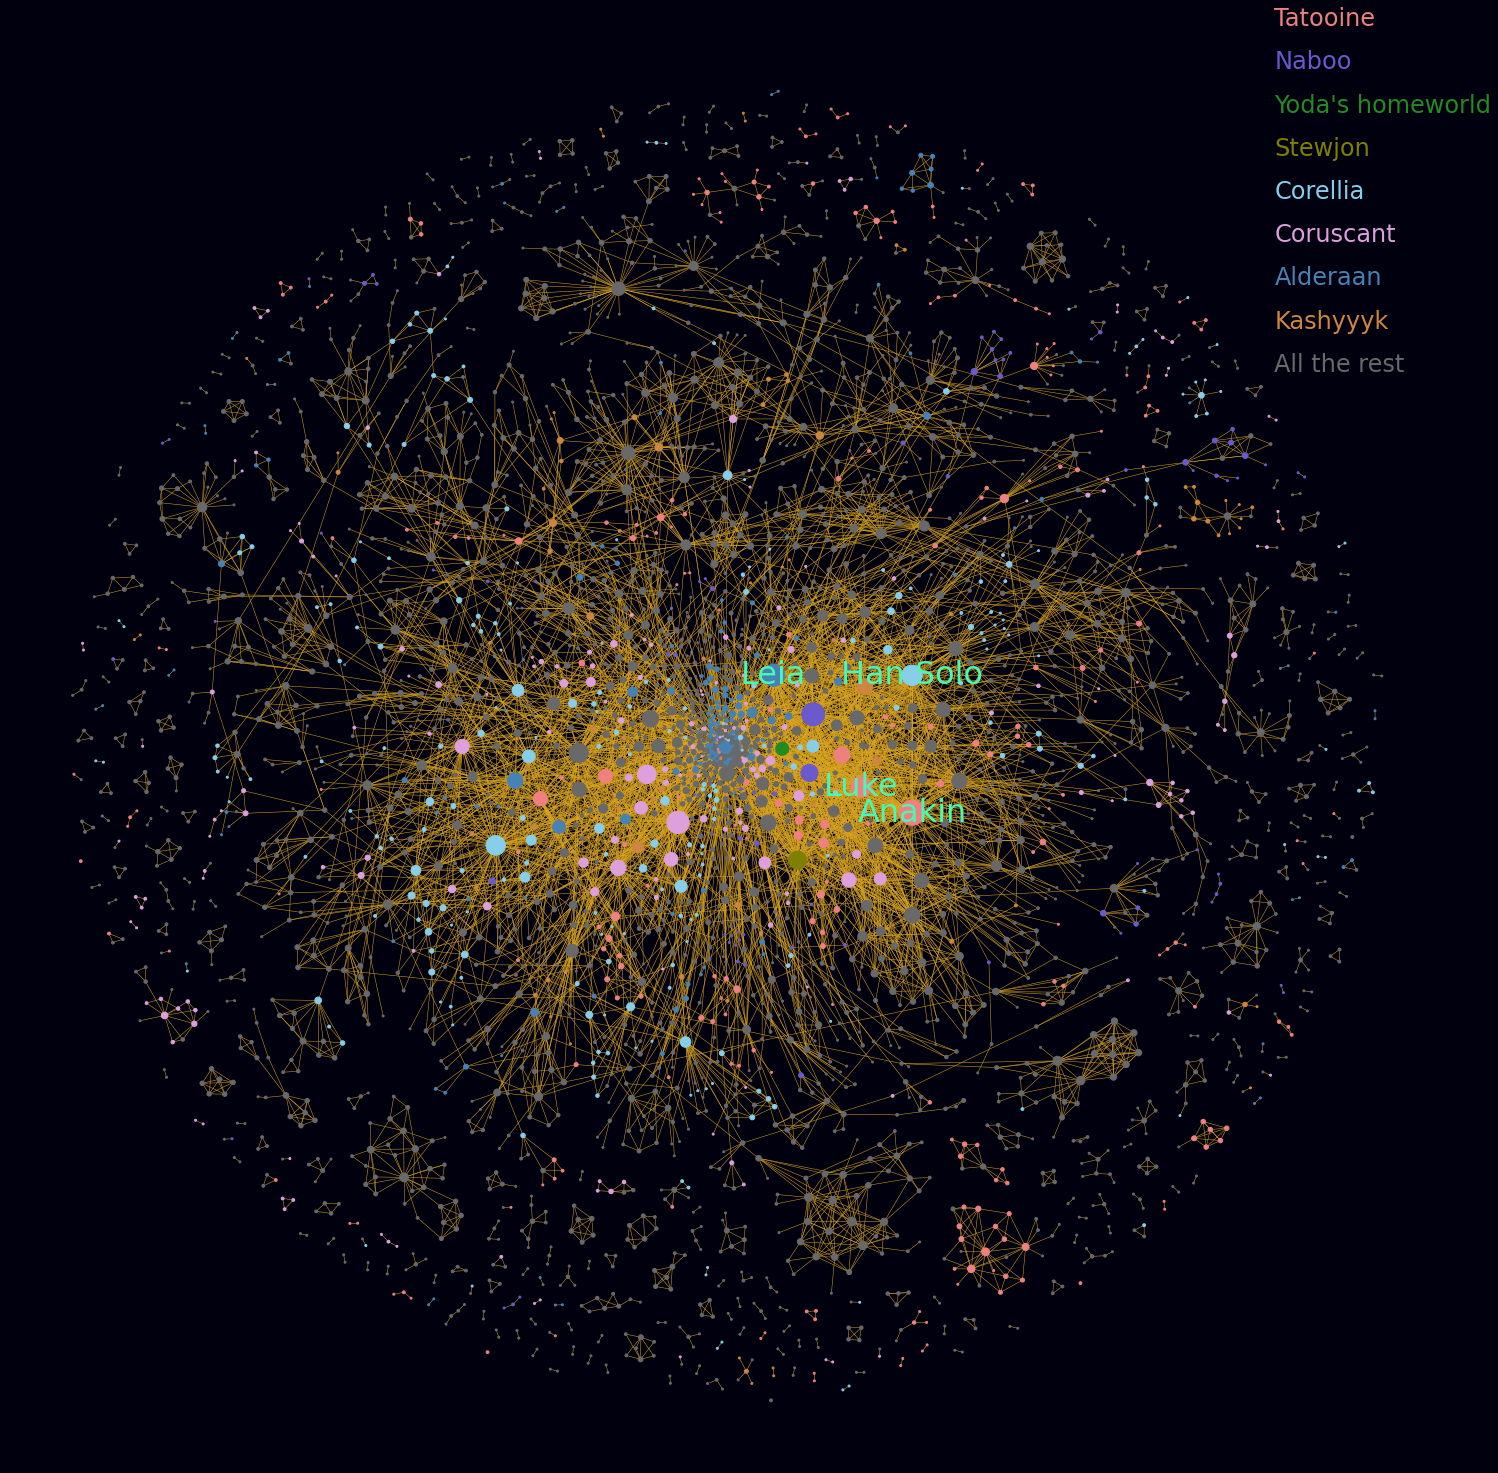

In [10]:
G = G.to_undirected()

forceatlas2 = ForceAtlas2(scalingRatio = 100, gravity = 1000)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

node_sizes = [degree*4 for degree in dict(G.degree()).values()]
node_colors = ['lightcoral' if temp == 'Tatooine' 
               else 'slateblue' if temp == 'Naboo' 
               else 'forestgreen' if temp == "Yoda's homeworld"
               else 'olive' if temp == 'Stewjon'
               else 'skyblue' if temp == 'Corellia'
               else 'plum' if temp == 'Coruscant'
               else 'steelblue' if temp == 'Alderaan'
               else 'peru' if temp == 'Kashyyyk'
               else 'dimgrey' for _, temp in nx.get_node_attributes(G, 'Homeworld').items()]

# Plotting
fig = plt.figure(figsize = (20, 20))
nx.draw(G, pos = positions, node_size = node_sizes, node_color = node_colors, edge_color='goldenrod', width = 0.5)
#nx.draw_networkx_labels(G, positions, {"Anakin Skywalker": "Anakin", "Leia Organa Solo": "Leia"}, 
#                        font_size=26, font_color='silver', font_weight='bold')
nx.draw_networkx_labels(G, positions, {"Anakin Skywalker": "Anakin", "Leia Skywalker Organa Solo": "Leia", 
                                       'Luke Skywalker': 'Luke', 'Han Solo':'Han Solo'}, 
                        font_size=32, font_color='#49F8B2')


plt.figtext(0.88, 1, 'Tatooine', size=24, color='lightcoral')
plt.figtext(0.88, 0.97, 'Naboo', size=24, color='slateblue')
plt.figtext(0.88, 0.94, "Yoda's homeworld", size=24, color='forestgreen')
plt.figtext(0.88, 0.91, 'Stewjon', size=24, color='olive')
plt.figtext(0.88, 0.88, 'Corellia', size=24, color='skyblue')
plt.figtext(0.88, 0.85, 'Coruscant', size=24, color='plum')
plt.figtext(0.88, 0.82, 'Alderaan', size=24, color='steelblue')
plt.figtext(0.88, 0.79, 'Kashyyyk', size=24, color='peru')
plt.figtext(0.88, 0.76, 'All the rest', size=24, color='dimgrey')
fig.set_facecolor("#00000F")
plt.savefig("Images/Networks/Big_Network.jpg", format="JPG")
plt.show()

Note: Two very big clusters

#### Calculate the nodes with the highest degree centrality

In [11]:
d_centrality = sorted(nx.degree_centrality(G).items(), 
                      key=lambda t: t[1], 
                      reverse=True)

for i in d_centrality[:5]:
    print(i)

('Leia Organa Solo', 0.06393606393606394)
('Anakin Skywalker', 0.03896103896103896)
('Darth Sidious', 0.03271728271728272)
('Darth Caedus', 0.03071928071928072)
('Leia Skywalker Organa Solo', 0.03071928071928072)


#### Calculate number of communities and the value of modularity

In [12]:
partition = community_louvain.best_partition(G)
communities_louvain = [[node for node in partition if partition[node] == cat] for cat in set(partition.values())]
modularity_louvain = nx.algorithms.community.modularity(G,communities_louvain)

print(f'Number of Communities: {len(set(partition.values()))}')
print(f'Value of Modularity: {modularity_louvain}')

Number of Communities: 444
Value of Modularity: 0.8374822009577764


### Network based on the six episodes

As there are too many nodes and edges it is better to concentrate to more specific nodes. As a result it was decided to select only the characters that appeared in the first six episodes.

#### Create the dataset

In [13]:
small_data = char[(char['First Trilogy']==1)|(char['Second Trilogy']==1)].reset_index(drop=True)

small_data.loc[(small_data['First Trilogy']==1) & (small_data['Second Trilogy']==0), 'Trilogy'] = 'First three episodes'
small_data.loc[(small_data['First Trilogy']==0) & (small_data['Second Trilogy']==1), 'Trilogy'] = 'Last three episodes'
small_data.loc[(small_data['First Trilogy']==1) & (small_data['Second Trilogy']==1), 'Trilogy'] = 'Both'

#### Create the network

In [14]:
G = nx.DiGraph()
for filename in os.listdir(os.path.join(os.getcwd(), 'Data/Characters')):
    if filename[:-4].replace('_',' ') in small_data['Name'].values:
        with open(os.path.join(os.path.join(os.getcwd(), 'Data/Characters'), filename), 'r') as f:
            contents = f.read()
            query_json = ast.literal_eval(contents)
            page_id = list(query_json['query']['pages'].keys())[0]
            string = query_json['query']['pages'][page_id]['revisions'][0]['slots']['main']['*']

            # Add nodes
            name = filename[:-4].replace('_',' ')
            G.add_node(name)

            # Add homeworld attribute
            G.nodes[name]['Homeworld'] = small_data.loc[small_data['Name']==name, 'Homeworld'].values[0]

            # Add species attribute
            G.nodes[name]['Species'] = small_data.loc[small_data['Name']==name, 'Species'].values[0]

            # Add gender
            G.nodes[name]['Gender'] = small_data.loc[small_data['Name']==name, 'Gender'].values[0]
            
            # Add trilogy
            G.nodes[name]['Trilogy'] = small_data.loc[small_data['Name']==name, 'Trilogy'].values[0]
            
            # Add edges
            pattern = '\[\[(.*?)(?:\|.*?)?\]\]'
            temp = re.findall(pattern, string)
            temp = list(small_data[small_data['Name'].isin(temp)]['Name'].drop_duplicates())
            for i in temp:
                G.add_edge(name, i)

G.remove_nodes_from(list(nx.isolates(G)))

#### Number of nodes

In [15]:
print("Number of nodes in the network:", G.number_of_nodes())

Number of nodes in the network: 218


#### Number of edges

In [16]:
print("Number of links in the network:", G.number_of_edges())

Number of links in the network: 1128


#### In-degree network

In [17]:
connections_in = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)
print('In Degree Connections:')
for character, in_degree in connections_in[:5]:
    node = G.nodes[character]
    print(character.ljust(30), 'In-degree:', in_degree)

In Degree Connections:
Anakin Skywalker               In-degree: 71
Luke Skywalker                 In-degree: 64
Han Solo                       In-degree: 51
Darth Sidious                  In-degree: 46
Leia Skywalker Organa Solo     In-degree: 45


#### Out-degree network

In [18]:
connections_out = sorted(dict(G.out_degree()).items(), key = lambda x: x[1], reverse = True)
print('\nOut Degree Connections:')
for character, out_degree in connections_out[:5]:
    node = G.nodes[character]
    print(character.ljust(30), 'Out-degree:', out_degree)


Out Degree Connections:
Anakin Skywalker               Out-degree: 50
Luke Skywalker                 Out-degree: 39
Leia Skywalker Organa Solo     Out-degree: 31
Obi-Wan Kenobi                 Out-degree: 29
R2-D2                          Out-degree: 28


#### Visualize the network

100%|██████████| 1000/1000 [00:01<00:00, 606.11it/s]


BarnesHut Approximation  took  0.44  seconds
Repulsion forces  took  0.99  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


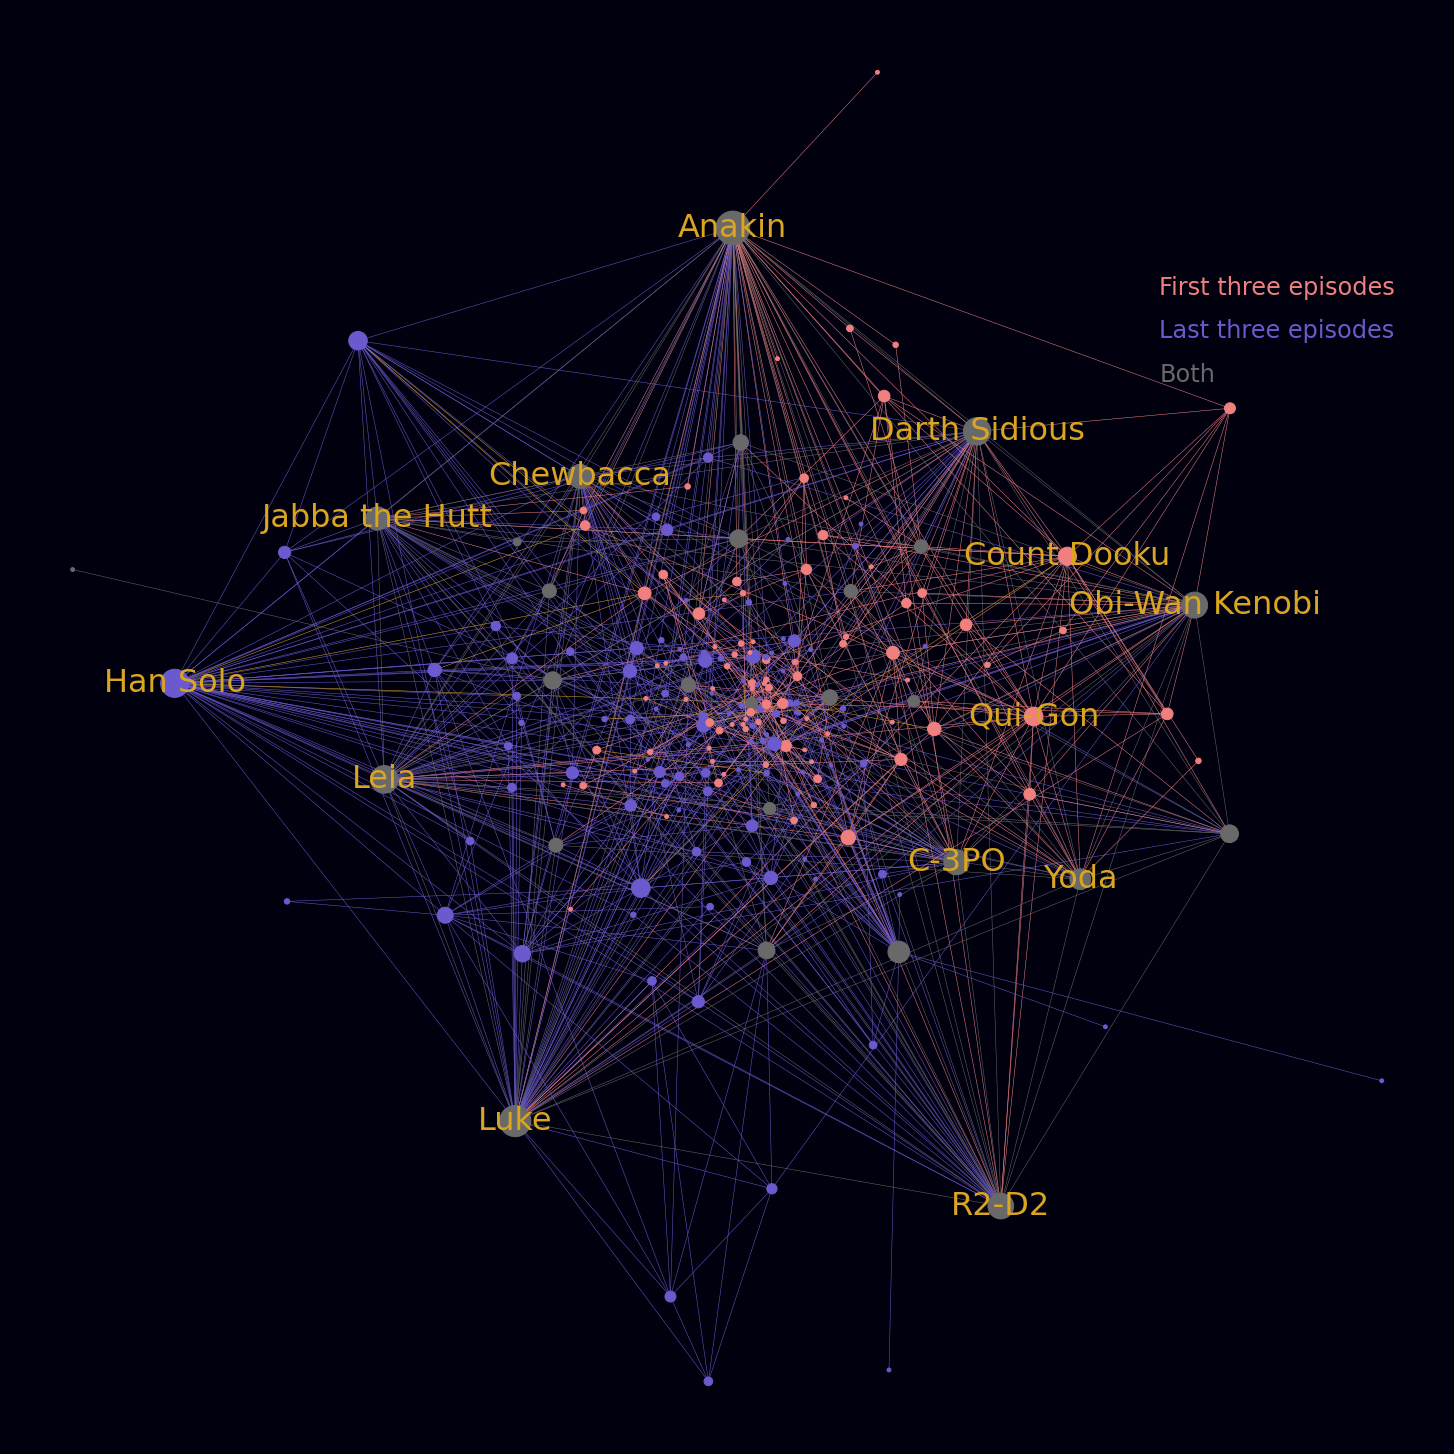

In [19]:
G = G.to_undirected()

# Function for colored edges
def edge_color(graph, node1, node2):
    role1, role2 = graph.nodes[node1]['Trilogy'], graph.nodes[node2]['Trilogy']
    if role1 == role2 == 'First three episodes':
        return 'lightcoral'
    elif role1 == role2 == 'Last three episodes':
        return 'slateblue'
    elif role1 == role2 == 'Both':
        return 'dimgrey'
    elif ((role1=='First three episodes') & (role2=='Both'))|((role2=='First three episodes') & (role1=='Both')):
        return 'lightcoral'
    elif ((role1=='Last three episodes') & (role2=='Both'))|((role2=='Last three episodes') & (role1=='Both')):
        return 'slateblue'
    else: 
        return 'goldenrod'

forceatlas2 = ForceAtlas2(scalingRatio = 100, gravity = 1000)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

node_sizes = [degree*15 for degree in dict(G.degree()).values()]
edge_colors = [edge_color(G, node1, node2) for node1, node2 in G.edges]
node_colors = ['lightcoral' if temp == 'First three episodes' 
               else 'slateblue' if temp == 'Last three episodes' 
               else 'dimgrey' for _, temp in nx.get_node_attributes(G, 'Trilogy').items()]

# Plotting
fig = plt.figure(figsize = (20, 20))
nx.draw(G, pos=positions, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width = 0.5)
nx.draw_networkx_labels(G, positions, {"Anakin Skywalker": "Anakin", "Leia Skywalker Organa Solo": "Leia", 
                                       'Luke Skywalker': 'Luke', 'Han Solo':'Han Solo', 'C-3PO':'C-3PO', 'R2-D2':'R2-D2',
                                       'Darth Sidious':'Darth Sidious','Obi-Wan Kenobi':'Obi-Wan Kenobi',
                                       'Chewbacca':'Chewbacca', 'Jabba Desilijic Tiure':'Jabba the Hutt',
                                       'Yoda':'Yoda', 'Dooku':'Count Dooku', 'Qui-Gon Jinn':'Qui-Gon'}, 
                        font_size=32, font_color='goldenrod')

plt.figtext(0.80, 0.8, 'First three episodes', size=24, color='lightcoral')
plt.figtext(0.80, 0.77, 'Last three episodes', size=24, color='slateblue')
plt.figtext(0.80, 0.74, 'Both', size=24, color='dimgrey')
fig.set_facecolor("#00000F")
plt.savefig("Images/Networks/Small_Network.png", format="PNG")
plt.show()

Cannot distinguish two different clusters.

#### Calculate the nodes with the highest degree centrality

In [20]:
d_centrality = sorted(nx.degree_centrality(G).items(), 
                      key=lambda t: t[1], 
                      reverse=True)

for i in d_centrality[:5]:
    print(i)

('Anakin Skywalker', 0.35023041474654376)
('Luke Skywalker', 0.2995391705069124)
('Han Solo', 0.24423963133640553)
('Leia Skywalker Organa Solo', 0.2350230414746544)
('Darth Sidious', 0.2304147465437788)


#### Calculate number of communities and the value of modularity

In [21]:
partition = community_louvain.best_partition(G)
communities_louvain = [[node for node in partition if partition[node] == cat] for cat in set(partition.values())]
modularity_louvain = nx.algorithms.community.modularity(G,communities_louvain)

print(f'Number of Communities: {len(set(partition.values()))}')
print(f'Value of Modularity: {modularity_louvain}')

Number of Communities: 26
Value of Modularity: 0.39395659130502164


#### Distribution of communities

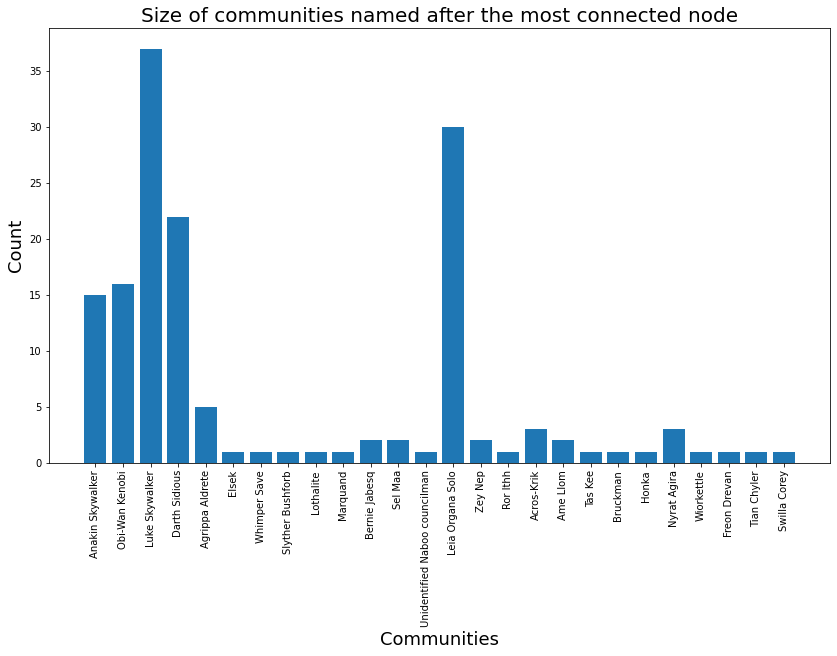

In [22]:
node_to_partition_id = community_louvain.best_partition(G)
partition_id_to_name = {partition_id: community_name(G, node_to_partition_id, partition_id) 
                        for partition_id in set(node_to_partition_id.values())}

community_size = {}
for key in partition_id_to_name.keys():
    community_size[partition_id_to_name[key][0][0]] = partition_id_to_name[key][0][1]
    
plt.figure(figsize=(14,8))
plt.bar(*zip(*community_size.items()))
plt.title('Size of communities named after the most connected node', fontsize=20)
plt.xlabel('Communities', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=90)
plt.savefig("Images/Plots/Dist_Community_Small_Network.png", format="PNG")
plt.show()

#### Read the sentiments of words

In [23]:
LabMT = pd.read_csv('./Files/Data_Set_S1.txt', sep="\t", skiprows = 2)
LabMT_dict = pd.Series(LabMT.happiness_average.values,index=LabMT.word.values).to_dict()

#### Create a dictionary for all the characters

In [24]:
#remove = [node for node,degree in dict(G.degree()).items() if degree < 10]
#G.remove_nodes_from(remove)

node_list = list(G.nodes())
corpus = {}
tokens = {}
for temp_char in node_list:
    path = os.path.join(os.getcwd(), "Data/Characters/", str(temp_char).replace(' ','_') + ".txt")
    with open(path ,encoding = 'utf-8') as f:
            corpus[temp_char] = (f.read()) 
for k, v in corpus.items():
    tokens[k] = list(set([w.lower() for w in word_tokenize(corpus[k]) if w.isalpha()]))
sentiment_dict_LabMT = {}
sentiment_dict_VADER = {}
for k,v in tokens.items():
    sentiment_dict_LabMT[k] = sentiment_function(tokens[k], LabMT_dict)
    sentiment_dict_VADER[k] = compute_sentiment_VADER(tokens[k])

sort_sentiment_dict = sorted(sentiment_dict_LabMT.items(),key=lambda x: x[1], reverse = True)
print('Happiest Characters (LabMT):')
for i in range(5):
    print(sort_sentiment_dict[i])
print('\nSaddest Characters (LabMT):')
for i in range(5):
    print(sort_sentiment_dict[-i-1])
    
sort_sentiment_dict = sorted(sentiment_dict_VADER.items(),key=lambda x: x[1], reverse = True)
print('\nHappiest Characters (VADER):')
for i in range(5):
    print(sort_sentiment_dict[i])
print('\nSaddest Characters (VADER):')
for i in range(5):
    print(sort_sentiment_dict[-i-1])

Happiest Characters (LabMT):
('Camie Loneozner', 4.26392156862745)
('Palejo Reshad', 4.26192307692308)
('Wuher', 4.257700000000002)
('Amee', 4.24344827586207)
('Niai Fieso', 4.220679156908671)

Saddest Characters (LabMT):
('Anakin Skywalker', 2.7021638372406334)
('Whimper Save', 2.946129032258064)
('Reha Logg', 2.953877551020408)
('Sateen Vestswe', 2.9573214285714284)
('Darth Sidious', 2.9868279465840915)

Happiest Characters (VADER):
('Kitster Banai', 0.0256273127753304)
('Acros-Krik', 0.02130754716981132)
('Romeo Treblanc', 0.01737134724857685)
('Ottegru Grey', 0.017093478260869564)
('Tyr Taskeen', 0.013882959048877146)

Saddest Characters (VADER):
('Nysad', -0.031507070707070706)
('Yma Nalle', -0.02705975609756097)
('Greeve (Human)', -0.025856989247311828)
('Sidewa', -0.02567543859649123)
('Serennian', -0.025622374429223747)


#### Distribution of sentiment scores (LabMT)

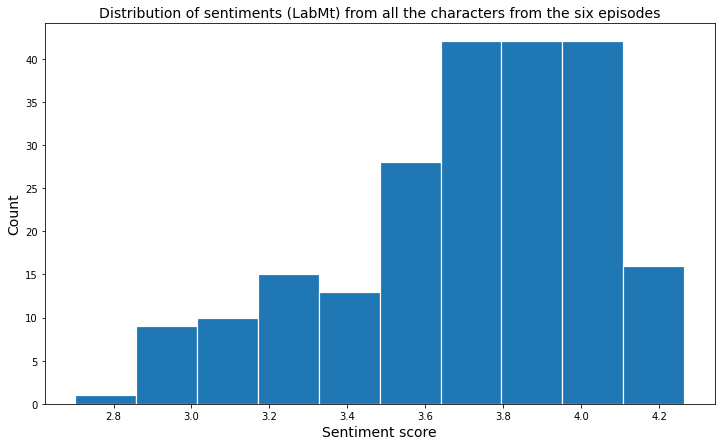

In [25]:
plt.figure(figsize=(12,7))
plt.hist(pd.Series(sentiment_dict_LabMT), edgecolor='white', linewidth=1.2)
plt.title('Distribution of sentiments (LabMt) from all the characters from the six episodes', fontsize =14)
plt.xlabel("Sentiment score", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.savefig("Images/Plots/Dist_LabMT_Small_Network.png", format="PNG")
plt.show()

#### Distribution of sentiment scores (VADER)

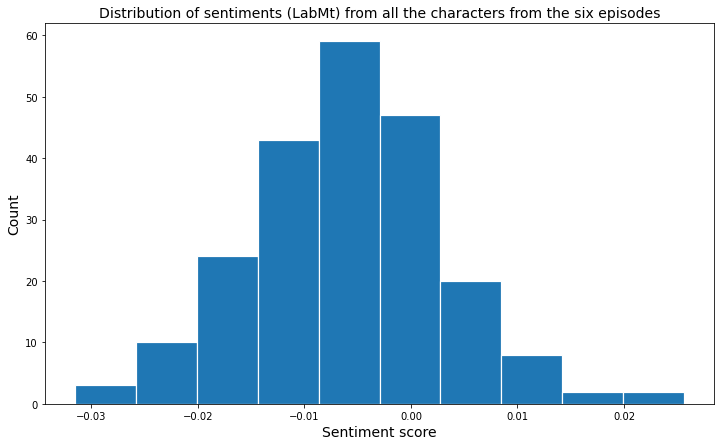

In [26]:
plt.figure(figsize=(12,7))
plt.hist(pd.Series(sentiment_dict_VADER), edgecolor='white', linewidth=1.2)
plt.title('Distribution of sentiments (LabMt) from all the characters from the six episodes', fontsize =14)
plt.xlabel("Sentiment score", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.savefig("Images/Plots/Dist_VADER_Small_Network.png", format="PNG")
plt.show()